<a href="https://colab.research.google.com/github/LeopoldoZanellato/Geral-DataScience/blob/master/Safety_isn't_optional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

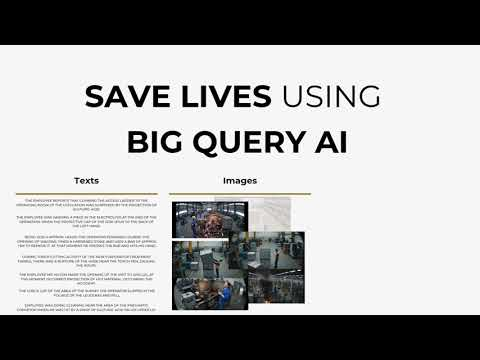

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('X6ny5kjq4VM', width=800, height=500)


# ⚙️ Project Configuration

Before running the pipeline, make sure to configure the environment variables.  
These variables control which **Google Cloud Project**, **Dataset**, **Storage Bucket**, and **Vertex AI connection** will be used.  

---

## 🔑 Mandatory Variables

- **`GOOGLE_CLOUD_PROJECT`** → Google Cloud Project ID  
- **`GOOGLE_CLOUD_DATASET`** → BigQuery Dataset name  
- **`CLOUD_STORAGE_BUCKET`** → Cloud Storage bucket for data/files  
- **`VERTEX_AI_CONNECTION`** → Vertex AI connection reference  

---

## 🛠 Optional Variables

- **`GOOGLE_CLOUD_MODEL`** → BigQuery AI model name (custom classifier)  
- **`GOOGLE_MODEL_TEMPERATURE`** → Model temperature (controls output randomness)  

---

✅ These variables must be set before executing the notebook.  


In [ ]:
#------------------------------MANDATORY VARIABLES-----------------------------#
# GOOGLE CLOUD PROJECT AND DATASET
GOOGLE_CLOUD_PROJECT = "kaggle-genai-469221"
GOOGLE_CLOUD_DATASET = "safety_analytics"

# GOOGLE CLOUD STORAGE BUCKET
CLOUD_STORAGE_BUCKET = "bigquery_kaggle"

# VERTEX AI CONNECTION
VERTEX_AI_CONNECTION = 'projects/kaggle-genai-469221/locations/us/connections/safetyanalytics_google'

#------------------------------OPTIONAL VARIABLES------------------------------#
# MODEL CONFIGURATION
GOOGLE_CLOUD_MODEL = "safety_classifier_model"
GOOGLE_MODEL_TEMPERATURE = 0.2

# 📚 Imports Overview

This project uses a core set of Python libraries for **data processing**, **visualization**, and **Google Cloud Platform (GCP) integration**.  
Below is a breakdown of the imports and their purposes:

---

## 🔢 Data Manipulation and Analysis
- **`pandas` (`pd`)**  
  Handles tabular data, DataFrame operations, CSV/Parquet I/O, and converts BigQuery results into Python-friendly formats.

- **`numpy` (`np`)**  
  Supports numerical and mathematical operations, enabling efficient array and matrix computations.

---

## 📊 Data Visualization
- **`seaborn` (`sns`)**  
  High-level visualization library (built on Matplotlib) for clean and statistical plotting.

- **`matplotlib.pyplot` (`plt`)**  
  Base plotting library for flexible chart creation and detailed figure customization.

---

## ☁️ Google Cloud Platform Integration
- **`google.cloud.bigquery`**  
  Interact with **BigQuery** for querying, creating, and managing datasets and tables.

- **`google.cloud.storage`**  
  Connect with **Google Cloud Storage (GCS)** to list, read, and manage files inside buckets.

---

## 💻 Google Colab Utilities (when running in Colab)
- **`from google.colab import auth`**  
  Authenticate Colab with Google Cloud services.

---


In [ ]:
# === Standard library ===
import os
import io
import time
from functools import reduce
import requests   # For making HTTP requests

# === Data manipulation & analysis ===
import pandas as pd
import numpy as np

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Google Cloud / Colab integration ===
from google.colab import auth
from google.cloud import bigquery, storage  # BigQuery + Cloud Storage clients

# === Kaggle integration ===
import kagglehub   # Kaggle utility functions (datasets, outputs, etc.)


# 🛡️ Occupational Safety Analysis (ILOSTAT Data)

---

## 1. Context

Instead of relying on Google Drive uploads, the notebook now **fetches OSH indicators directly from ILOSTAT’s public API**.  
This provides the most recent and standardized data aligned with **SDG 8.8.1** (Safe and Secure Working Environments).  

The objective is to analyze how **occupational fatality rates** relate to the **availability of labor inspectors** across countries.  

---

## 2. Indicators Downloaded

The following indicators are retrieved from ILOSTAT:

- **`non_fatal_occupation_per_100_000`** → Non-fatal occupational injuries per 100K workers.  
- **`fatal_occupation_per_100_000`** → Fatal occupational injuries per 100K workers.  
- **`inspectors_per_100_000`** → Number of labor inspectors per 100K employees (normalized in code from 10K → 100K).  

---

## 3. Data Preparation

- API responses are converted into tidy DataFrames (`country`, `obs_value`).  
- Columns are merged into a single dataset (`df_safety`) using `country` as the key.  
- Values are converted to numeric and rescaled when necessary.  
- Only rows with at least one valid metric are kept.  

---

## 4. Top 30 Fatality Rates 📊

A **bar + line chart** highlights the 30 countries with the highest fatality rates:

- **Blue bars** → Fatal occupational injuries per 100K workers.  
- **Red line** → Number of labor inspectors per 10K employees.  

🔎 Observations:  
- Countries with **high fatalities but very few inspectors** expose **weak enforcement capacity**.  
- Example: **Cuba**, **Dominican Republic**, and **Togo** stand out with elevated fatality rates.  
- Nations with a stronger inspector presence tend to show **lower fatality rates**.

---

## 5. Lowest 30 Fatality Rates 📉

Another chart focuses on the **30 countries with the lowest fatality rates**:

- **Blue bars** again represent fatalities.  
- **Red line** shows inspectors per 10K employees.  

🔎 Observations:  
- Countries in this group usually combine **low fatality rates with a higher inspector density**.  
- This reinforces the **correlation between inspection capacity and safer workplaces**.  

---

## 6. Conclusion ✅

The results confirm that **labor inspection policies** play a central role in reducing occupational fatalities.  
These indicators are crucial to track progress toward **SDG 8 (Decent Work and Economic Growth)** and highlight areas where **institutional strengthening** is required.




In [ ]:
# -------------------------------------------------------------------
# Download OSH indicators directly from ILOSTAT
# -------------------------------------------------------------------

BASE = "https://rplumber.ilo.org/data/indicator/"
COMMON = "&sex=SEX_T&classif1=MIG_STATUS_TOTAL&latestyear=TRUE&type=label&format=.csv"

INDICATORS = {
    "non_fatal_occupation_per_100_000": "SDG_N881_SEX_MIG_RT_A",
    "fatal_occupation_per_100_000":     "SDG_F881_SEX_MIG_RT_A",
    "inspectors_per_100_000":           "LAI_INDE_NOC_RT_A",  # usually per 10,000 employees
}

HEADERS = {
    "User-Agent": "Mozilla/5.0",
    "Referer": "https://ilostat.ilo.org/"
}

def fetch_indicator(code: str, max_retries: int = 3, backoff: float = 1.5) -> pd.DataFrame:
    """
    Fetch a single indicator as CSV and return a tidy DataFrame with columns:
    - 'country'
    - '<metric column>' (renamed later by caller)
    Implements simple retries to handle transient 403/5xx responses.
    """
    url = f"{BASE}?id={code}{COMMON}"
    last_err = None

    with requests.Session() as s:
        s.headers.update(HEADERS)
        for attempt in range(1, max_retries + 1):
            try:
                resp = s.get(url, timeout=60)
                resp.raise_for_status()
                df = pd.read_csv(io.StringIO(resp.text))
                # Standardize column names we need
                if "ref_area.label" not in df.columns or "obs_value" not in df.columns:
                    raise ValueError(f"Unexpected schema for indicator {code}. Columns: {list(df.columns)}")
                return df.rename(columns={"ref_area.label": "country"})[["country", "obs_value"]]
            except Exception as e:
                last_err = e
                if attempt < max_retries:
                    time.sleep(backoff ** attempt)
                else:
                    raise last_err

dfs = []
for colname, code in INDICATORS.items():
    df_i = fetch_indicator(code)
    df_i = df_i.rename(columns={"obs_value": colname})
    dfs.append(df_i)

# Merge all indicators by country
df_safety = reduce(lambda left, right: pd.merge(left, right, on="country", how="outer"), dfs)

# Convert to numeric and clean
for col in ["non_fatal_occupation_per_100_000",
            "fatal_occupation_per_100_000",
            "inspectors_per_100_000"]:
    df_safety[col] = pd.to_numeric(df_safety[col], errors="coerce")

# Normalize inspectors from per 10,000 to per 100,000 to match the other metrics
if "inspectors_per_100_000" in df_safety.columns:
    df_safety["inspectors_per_100_000"] = df_safety["inspectors_per_100_000"] * 10

# Optional: basic sanity filters (keep rows with at least one metric present)
df_safety = df_safety.dropna(how="all", subset=[
    "non_fatal_occupation_per_100_000",
    "fatal_occupation_per_100_000",
    "inspectors_per_100_000"
])

# Preview
print("Preview:")
display(df_safety.head())

# Optional: save to CSV (uncomment if you want a local/Drive copy)
# df_safety.to_csv("/content/df_safety.csv", index=False)

"""
This DataFrame contains occupational safety and health (OSH) indicators aligned to SDG 8.8.1:
- non_fatal_occupation_per_100_000: Non-fatal occupational injuries per 100K workers
- fatal_occupation_per_100_000: Fatal occupational injuries per 100K workers
- inspectors_per_100_000: Labor inspectors per 100K employees (normalized here to 100K)
"""


Preview:


,country,non_fatal_occupation_per_100_000,fatal_occupation_per_100_000,inspectors_per_100_000
0,Algeria,1002.700,17.590,NaN
1,Argentina,3608.708,3.260,2.7
2,Armenia,29.400,4.190,11.0
3,Aruba,NaN,NaN,23.0
4,Australia,1029.158,1.422,9.9


'\nThis DataFrame contains occupational safety and health (OSH) indicators aligned to SDG 8.8.1:\n- non_fatal_occupation_per_100_000: Non-fatal occupational injuries per 100K workers\n- fatal_occupation_per_100_000: Fatal occupational injuries per 100K workers\n- inspectors_per_100_000: Labor inspectors per 100K employees (normalized here to 100K)\n'

In [ ]:
df_safety.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   country                           108 non-null    object 
 1   non_fatal_occupation_per_100_000  98 non-null     float64
 2   fatal_occupation_per_100_000      100 non-null    float64
 3   inspectors_per_100_000            85 non-null     float64
dtypes: float64(3), object(1)
memory usage: 3.5+ KB


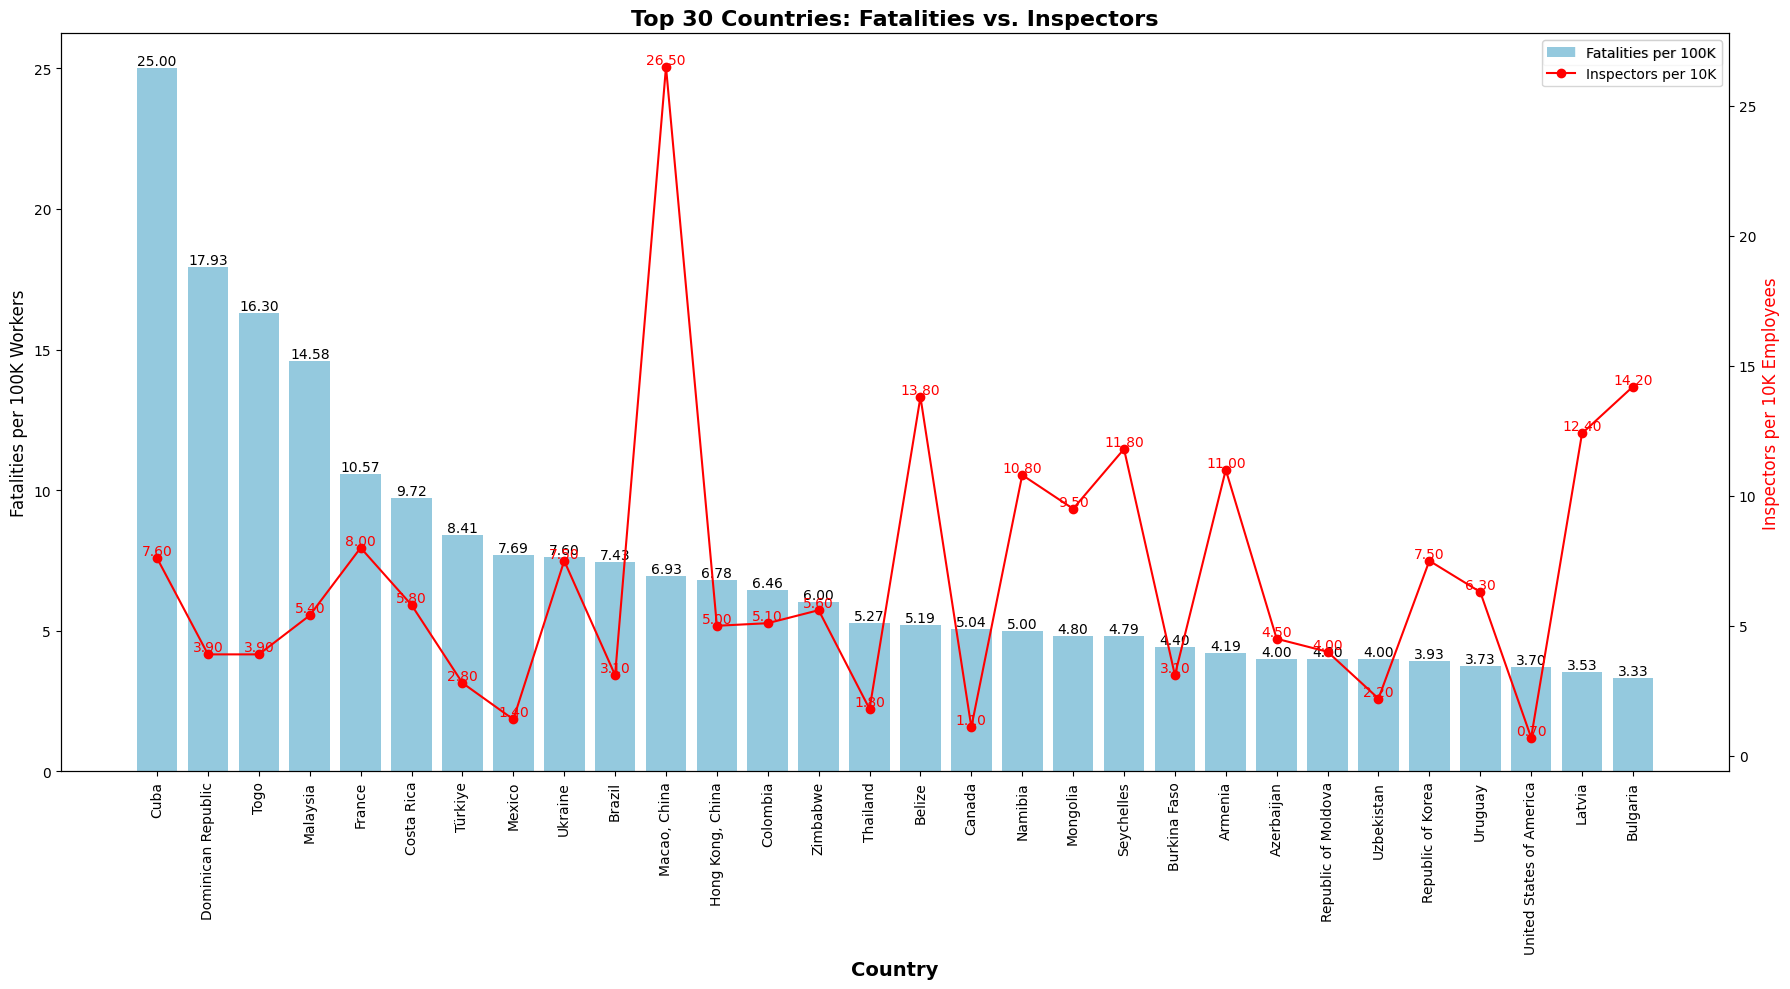

In [ ]:
# --- Data Analysis & Visualization ---

# Columns of interest (define at the start for clarity)
COL_FATAL = 'fatal_occupation_per_100_000'
COL_INSPECTORS = 'inspectors_per_100_000'
COL_COUNTRY = 'country'

# 1. Data Preparation

# Filter rows with non-null values in relevant columns
df_filtered = df_safety.dropna(subset=[COL_FATAL, COL_INSPECTORS]).copy()

# 2. Select Top 30 Countries with Most Fatalities

# Sort descending by fatalities and select top 30
df_top_30_fatalities = df_filtered.sort_values(by=COL_FATAL, ascending=False).head(30).copy()

# 3. Multi-Axis Chart

# Set figure size
fig, ax1 = plt.subplots(figsize=(18, 10))

# --- Primary Axis (ax1) ---
# Bar plot for fatalities
sns.barplot(
    x=COL_COUNTRY,
    y=COL_FATAL,
    data=df_top_30_fatalities,
    ax=ax1,
    color='skyblue',
    label='Fatalities per 100K'
)

# Add value labels on bars
for p in ax1.patches:
    ax1.text(
        p.get_x() + p.get_width() / 2.,
        p.get_height(),
        f'{p.get_height():.2f}',
        ha='center', va='bottom',
        fontsize=10
    )

# --- Secondary Axis (ax2) ---
# Line plot for inspectors
ax2 = ax1.twinx()
ax2.plot(
    df_top_30_fatalities[COL_COUNTRY],
    df_top_30_fatalities[COL_INSPECTORS],
    marker='o',
    linestyle='-',
    color='red',
    label='Inspectors per 10K'
)

# Add value labels on line points
for i, insp_value in enumerate(df_top_30_fatalities[COL_INSPECTORS]):
    ax2.text(
        i,
        insp_value,
        f'{insp_value:.2f}',
        ha='center', va='bottom',
        color='red', fontsize=10
    )

# 4. Chart Configuration

# Axis labels and title
ax1.set_xlabel('Country', fontsize=14, fontweight='bold')
ax1.set_ylabel('Fatalities per 100K Workers', fontsize=12)
ax2.set_ylabel('Inspectors per 10K Employees', color='red', fontsize=12)
plt.title('Top 30 Countries: Fatalities vs. Inspectors', fontsize=16, fontweight='bold')

# Rotate x-axis labels
ax1.tick_params(axis='x', rotation=90)

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Optimize layout
plt.tight_layout()

# Show chart
plt.show()

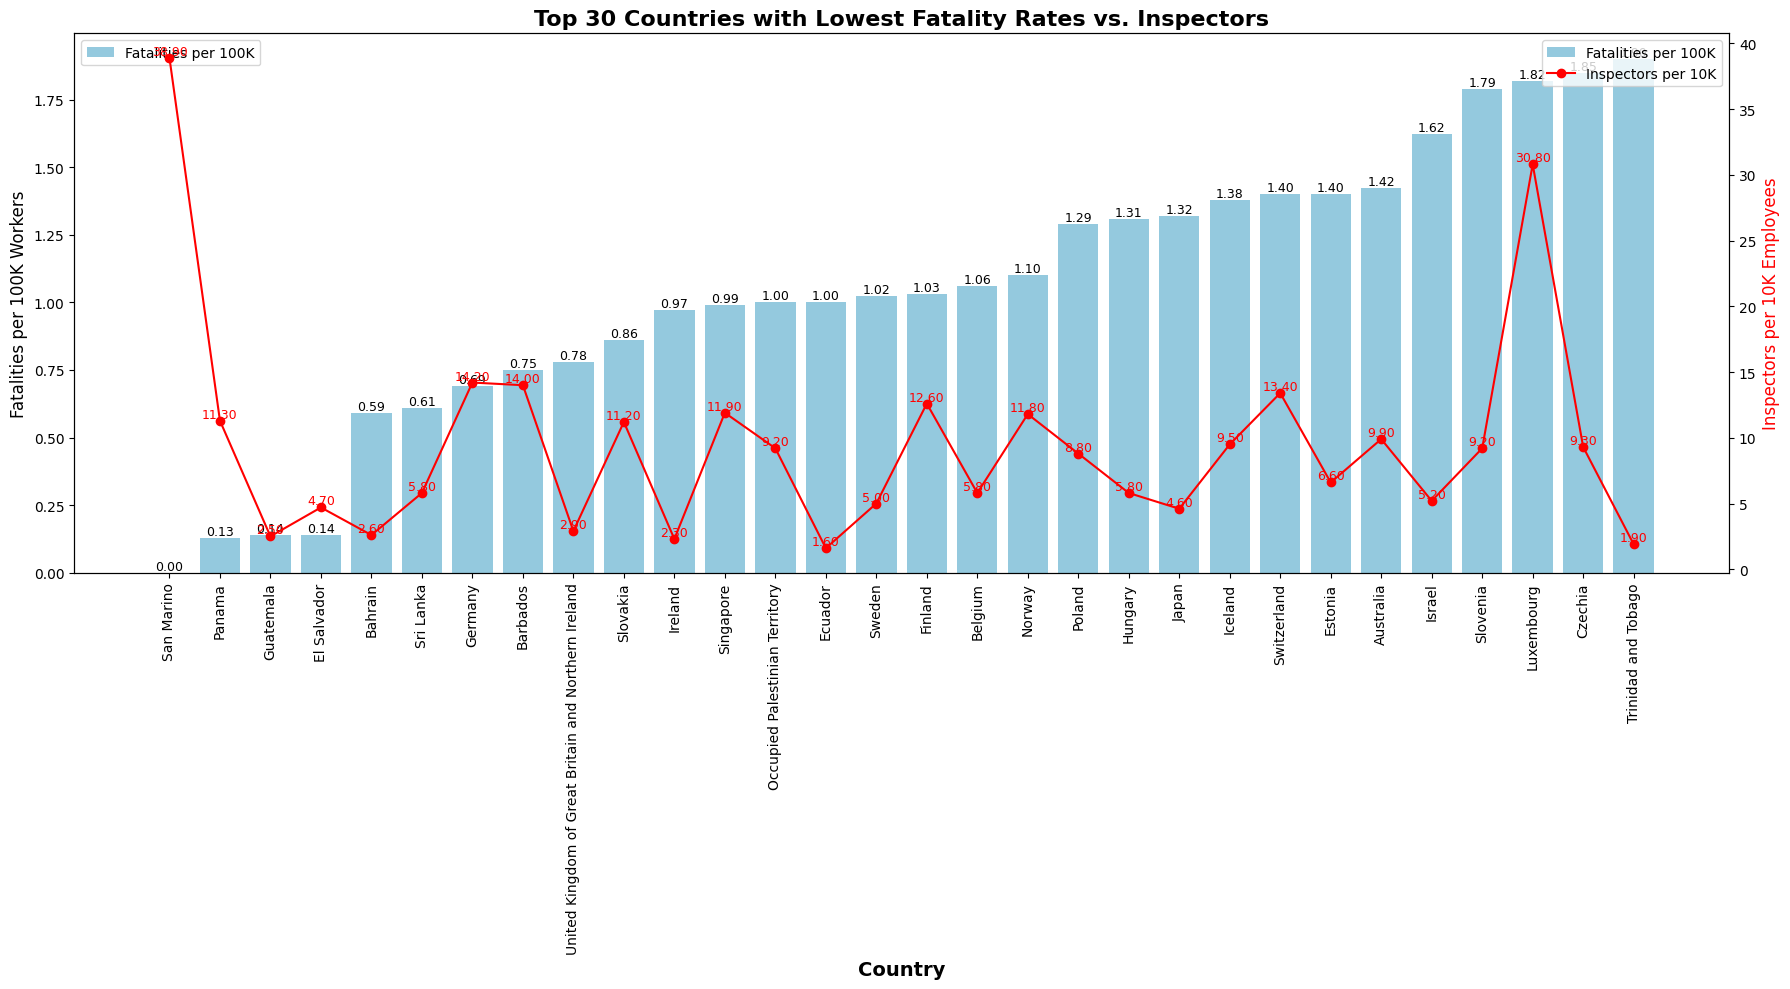

In [ ]:
# --- Data Analysis & Visualization (Lowest Fatality Rates) ---

# Define columns of interest (using variables improves maintainability)
COL_FATAL = 'fatal_occupation_per_100_000'
COL_INSPECTORS = 'inspectors_per_100_000'
COL_COUNTRY = 'country'

# 1. Data Preparation

# Filter rows with non-null values in key columns
df_filtered = df_safety.dropna(subset=[COL_FATAL, COL_INSPECTORS]).copy()

# 2. Select 30 Countries with the Lowest Fatality Rates

# Sort ascending and take the first 30
df_bottom_30_fatalities = df_filtered.sort_values(by=COL_FATAL, ascending=True).head(30).copy()

# 3. Multi-Axis Chart

# Set figure size
fig, ax1 = plt.subplots(figsize=(18, 10))

# --- Primary Axis (ax1) ---
# Bar plot for fatalities
sns.barplot(
    x=COL_COUNTRY,
    y=COL_FATAL,
    data=df_bottom_30_fatalities,
    ax=ax1,
    color='skyblue',
    label='Fatalities per 100K'
)

# Add value labels to bars
for p in ax1.patches:
    ax1.text(
        p.get_x() + p.get_width() / 2.,
        p.get_height(),
        f'{p.get_height():.2f}',
        ha='center', va='bottom',
        fontsize=9
    )

# --- Secondary Axis (ax2) ---
# Line plot for inspectors
ax2 = ax1.twinx()
ax2.plot(
    df_bottom_30_fatalities[COL_COUNTRY],
    df_bottom_30_fatalities[COL_INSPECTORS],
    marker='o',
    linestyle='-',
    color='red',
    label='Inspectors per 10K'
)

# Add value labels to line points
for i, insp_value in enumerate(df_bottom_30_fatalities[COL_INSPECTORS]):
    ax2.text(
        i,
        insp_value,
        f'{insp_value:.2f}',
        ha='center', va='bottom',
        color='red', fontsize=9
    )

# 4. Chart Configuration

# Axis labels and title
ax1.set_xlabel('Country', fontsize=14, fontweight='bold')
ax1.set_ylabel('Fatalities per 100K Workers', fontsize=12)
ax2.set_ylabel('Inspectors per 10K Employees', color='red', fontsize=12)
plt.title('Top 30 Countries with Lowest Fatality Rates vs. Inspectors', fontsize=16, fontweight='bold')

# Rotate x-axis labels
ax1.tick_params(axis='x', rotation=90)

# Remove secondary axis grid
ax2.grid(False)

# Combine and show legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Adjust layout
plt.tight_layout()

# Show chart
plt.show()


# 📥 Data Ingestion: Kaggle → Preprocessing → BigQuery

---

## 1) Downloading the Public Kaggle Dataset

The dataset is fetched programmatically using `kagglehub.dataset_download()`.  

- **Dataset path** → `ihmstefanini/industrial-safety-and-health-analytics-database`  
- **Output** → A local directory containing the CSV files  
- **Why this method?**  
  - Automates ingestion (no manual upload needed)  
  - Ensures reproducibility in hosted environments like Colab  

**Workflow:**  
1. Define `PATH_DATABASE`.  
2. Call `kagglehub.dataset_download(PATH_DATABASE)`.  
3. Load the CSV into a DataFrame with `pandas.read_csv()`.  

---

## 2) Basic Preprocessing ⚙️

After loading the CSV:

- Add a column **`source` = "Text"** to tag the origin.  
- Rename **`Unnamed: 0` → `index_`** to avoid default Pandas naming confusion.  
- Preview the first rows to validate schema alignment.  

This ensures the dataset is standardized before ingestion into BigQuery.  

---

## 3) Authentication 🔐

The notebook authenticates the Colab session to access Google Cloud:  

- **`auth.authenticate_user()`** → Authenticate account.  
- **`bigquery.Client(project=GOOGLE_CLOUD_PROJECT)`** → Initialize client.  

---

## 4) Loading Data into BigQuery ☁️

The DataFrame is uploaded to the **target table**:  
`kaggle-genai-469221.safety_analytics.safety_accidents`  

- **Load configuration**:  
  - `WRITE_TRUNCATE` → Overwrites table each run, keeping it perfectly aligned with the DataFrame.  
- **Execution steps**:  
  1. Define `LoadJobConfig`.  
  2. Submit with `client.load_table_from_dataframe()`.  
  3. Wait for completion with `job.result()`.  
  4. Print `job.output_rows` for confirmation.  

---

## 5) Generative AI Classification 🤖

A **bronze table** (`tb_bronze_safety_accidents`) is created by applying **BigQuery Generative AI** on the `Description` field:  

- **Function used**: `AI.GENERATE_TABLE()`  
- **Tasks performed**:  
  - Classify incidents into predefined categories (`incident_type`, `root_cause`).  
  - Detect PPE usage and PPE condition (`is_ppe_used`, `is_ppe_ok`).  
  - Generate a concise `summary`.  
- **Output schema** defined with structured fields to ensure valid JSON.  
- **Temperature** is configurable via `GOOGLE_MODEL_TEMPERATURE`.  

---

## 6) Summary ✅

This stage:  
1. **Downloaded** the dataset from Kaggle.  
2. **Standardized** it (source tagging + column renaming).  
3. **Authenticated & loaded** the dataset into BigQuery.  
4. **Created a bronze table** with AI-powered enrichment using `AI.GENERATE_TABLE`.  

This establishes the **foundation layer** of the data pipeline.  


## 7. Project Architecture
![Project Architecture](https://drive.google.com/uc?export=view&id=1CUQiy7aZgtkaHsf7gRZTrNN39Pfu2BZj)

In [ ]:
# === Download Kaggle public dataset ===

# Dataset path identifier from Kaggle
PATH_DATABASE = "ihmstefanini/industrial-safety-and-health-analytics-database"

print("Downloading Kaggle dataset...")
# Download the dataset locally using kagglehub
path = kagglehub.dataset_download(PATH_DATABASE)

# Confirm where the dataset has been stored
print(f"Dataset successfully downloaded to: {path}")

# === Load CSV into a DataFrame ===

# Relative path of the target CSV inside the downloaded folder
NAME_CSV = "/IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv"

# Load the CSV into a pandas DataFrame
df_train = pd.read_csv(path + NAME_CSV)


Dataset successfully downloaded to: /kaggle/input/industrial-safety-and-health-analytics-database


In [ ]:
df_train.head()

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...


In [ ]:
# basic pre processing
df_train['source'] = "Text" # all registers from text

df_train = df_train.rename(columns={'Unnamed: 0': 'index_'})

df_train.head()

,index_,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description,source
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,Text
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,Text
2,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,Text
3,3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,Text
4,4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,Text


In [ ]:
# Authenticate user for Google Cloud
auth.authenticate_user()

# Initialize BigQuery client
client = bigquery.Client(project=GOOGLE_CLOUD_PROJECT)


In [ ]:
# --- Upload Data to BigQuery ---

# Full table reference: project.dataset.table
table_id = f"{GOOGLE_CLOUD_PROJECT}.{GOOGLE_CLOUD_DATASET}.safety_accidents"

# Load job configuration
# WRITE_TRUNCATE = overwrite table each run (keeps table in sync with DataFrame)
job_config = bigquery.LoadJobConfig(
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE,
)

# Submit load job (upload pandas DataFrame to BigQuery)
job = client.load_table_from_dataframe(
    df_train, table_id, job_config=job_config
)

# Block until job is complete
job.result()

# Confirm completion and number of rows inserted
print(f"Data successfully loaded: {job.output_rows} rows into {table_id}")


Data successfully loaded: 425 rows into kaggle-genai-469221.safety_analytics.safety_accidents


In [ ]:
# --- Query Execution with Generative AI in BigQuery ---

# 1. Define SQL query
# - Creates or replaces a target table
# - Uses AI.GENERATE_TABLE on column 'Description'
sql_query = f"""
CREATE OR REPLACE TABLE `{GOOGLE_CLOUD_PROJECT}.{GOOGLE_CLOUD_DATASET}.tb_bronze_safety_accidents` AS
WITH gen_table AS (
  SELECT *
  FROM `{GOOGLE_CLOUD_PROJECT}.{GOOGLE_CLOUD_DATASET}.safety_accidents`
)
SELECT *
FROM AI.GENERATE_TABLE(
  MODEL `{GOOGLE_CLOUD_PROJECT}.{GOOGLE_CLOUD_DATASET}.{GOOGLE_CLOUD_MODEL}`,
  (
    -- Subquery must output a column named 'prompt'
    SELECT CONCAT(
      'Classify the incident into:', '\\n',
      '- incident_type (choose one): ["crushing_pinch","slip_fall_same_level","fall_from_height","struck_by_caught_between","chemical_thermal_exposure","projection_flying_object","mechanical_breakdown_failure","electrocution_electrical_arc","ergonomic_overexertion","animal_insect_bite","vehicle_mobile_equipment","tool_hand_tool_injury","other"]', '\\n',
      '- root_cause (choose one): ["human_error","procedural_failure","equipment_failure","environmental_hazard","inadequate_ppe","lack_of_communication","unstable_material_structure","other"]', '\\n',
      '- is_ppe_used (BOOL): true/false/null (use "null" if not mentioned)', '\\n',
      '- is_ppe_ok (BOOL): true/false/null (use "null" if not mentioned)', '\\n',
      'Also provide a short "summary". Respond only with valid JSON.', '\\n',
      'Text: ', Description, '\\n',
      'Record ID: ', index_
    ) AS prompt
    FROM gen_table
  ),
  STRUCT(
    "is_ppe_ok STRING, is_ppe_used STRING, incident_type STRING, root_cause STRING, accident_category STRING, summary STRING, id STRING" AS output_schema,
    {GOOGLE_MODEL_TEMPERATURE} AS temperature
  )
);
"""

# 2. Execute query
print("Submitting BigQuery job...")
job = client.query(sql_query)

# 3. Wait for completion
job.result()

# 4. Confirmation
print("Job completed successfully.")
print("Table tb_bronze_safety_accidents created or replaced.")

Submitting BigQuery job...
Job completed successfully.
Table tb_bronze_safety_accidents created or replaced.


# 🪙 Silver Layer: Data Join & Enrichment

---

## 1) Purpose

The **Silver Layer** consolidates raw records from Kaggle with **AI-enriched classifications** generated in the Bronze Layer.  
This step produces a **clean, standardized, and analytics-ready table**:  
`tb_silver_incidents_enriched`.

---

## 2) Workflow

### Step 1: Base Tables
- **Raw data (alias `a`)** → `safety_accidents`  
  - Contains original fields (date, country, sector, description).  
- **AI-generated data (alias `ia`)** → `tb_bronze_safety_accidents`  
  - Contains structured labels and summaries generated by `AI.GENERATE_TABLE`.

### Step 2: Join Strategy
- Perform a **LEFT JOIN** to ensure all original rows are kept.  
- Key: `index_` from raw table (cast as `STRING`) matched to `id` from AI output.  

### Step 3: Output Columns
- **From raw accidents**:  
  - `index_`, `Data`, `Countries`, `Local`, `industry_sector`, `genre`, `employee_thirdparty`, `Description`, `source`.  
- **From AI enrichment**:  
  - `accident_category`, `incident_type`, `is_ppe_ok`, `is_ppe_used`, `summary`, `full_response`, `prompt`.  

---

## 3) Validation ✅

A quick sample check confirms the enriched schema:  

```sql
SELECT *
FROM tb_silver_incidents_enriched
LIMIT 5;


In [ ]:
# --- Data Join & Enrichment in BigQuery ---

# 1. SQL query definition
# - Joins raw accidents table (a) with AI-enriched classifications (ia)
# - Creates a clean/enriched table for downstream use
sql_query = f"""
CREATE OR REPLACE TABLE `{GOOGLE_CLOUD_PROJECT}.{GOOGLE_CLOUD_DATASET}.tb_silver_incidents_enriched` AS
SELECT
    -- Original fields
    a.index_,
    a.Data,
    a.Countries,
    a.Local,
    a.`Industry Sector` AS industry_sector,   -- renamed to snake_case
    a.Genre,
    a.`Employee or Third Party` AS employee_thirdparty,   -- renamed for clarity
    a.Description,
    a.source,

    -- AI-generated fields
    ia.accident_category,
    ia.incident_type,
    ia.is_ppe_ok,
    ia.is_ppe_used,
    ia.summary,
    ia.full_response,
    ia.prompt

FROM `{GOOGLE_CLOUD_PROJECT}.{GOOGLE_CLOUD_DATASET}.safety_accidents` AS a
LEFT JOIN `{GOOGLE_CLOUD_PROJECT}.{GOOGLE_CLOUD_DATASET}.tb_bronze_safety_accidents` AS ia
ON CAST(a.index_ AS STRING) = ia.id;   -- join key normalized as string
"""

# 2. Execute query
print("Submitting BigQuery job to build enriched dataset...")
job = client.query(sql_query)

# 3. Wait until it finishes
job.result()

# 4. Confirmation
print("Job completed successfully.")
print("Table tb_silver_incidents_enriched created/replaced with joined data.")



Submitting BigQuery job to build enriched dataset...
Job completed successfully.
Table tb_silver_incidents_enriched created/replaced with joined data.


In [ ]:
# --- Visualization & Validation of Enriched Data ---

# 1. SQL query: fetch a small sample for inspection
sql_query = f"""
SELECT *
FROM `{GOOGLE_CLOUD_PROJECT}.{GOOGLE_CLOUD_DATASET}.tb_silver_incidents_enriched`
LIMIT 5;
"""

# 2. Execute query and return as pandas DataFrame
print("Fetching sample data from enriched table...")
df = client.query(sql_query).to_dataframe()

# 3. Display sample for quick validation
print("Data fetched successfully. Preview of 5 rows:")
display(df)

Fetching sample data from enriched table...
Data fetched successfully. Preview of 5 rows:


,index_,Data,Countries,Local,industry_sector,Genre,employee_thirdparty,Description,source,accident_category,incident_type,is_ppe_ok,is_ppe_used,summary,full_response,prompt
0,123,2016-05-04 00:00:00,Country_02,Local_05,Metals,Female,Third Party (Remote),When conducting inspection to evaluate activit...,Text,None,chemical_thermal_exposure,None,None,Worker exposed to sulfuric acid spill from an ...,"{""candidates"":[{""avg_logprobs"":-1.867003160364...",Classify the incident into:\n- incident_type (...
1,238,2016-09-27 00:00:00,Country_01,Local_06,Metals,Female,Third Party,"At 14: 55h on 27 September, a worker from Conf...",Text,None,struck_by_caught_between,None,None,A worker was struck in the lips by a released ...,"{""candidates"":[{""avg_logprobs"":-4.748933701288...",Classify the incident into:\n- incident_type (...
2,29,2016-02-16 00:00:00,Country_02,Local_07,Mining,Male,Employee,When using the griff wrench to unscrew the rod...,Text,Pinch Point Injury,struck_by_caught_between,,None,None,"{""candidates"":[{""avg_logprobs"":-3.234639254483...",Classify the incident into:\n- incident_type (...
3,118,2016-05-01 00:00:00,Country_01,Local_04,Mining,Male,Third Party,When carrying out the maneuver to increase the...,Text,Caught Between,struck_by_caught_between,,,An assistant's hand was caught and injured by ...,"{""candidates"":[{""avg_logprobs"":-0.804495334625...",Classify the incident into:\n- incident_type (...
4,83,2016-03-31 00:00:00,Country_01,Local_06,Metals,Male,Employee,Being approximately 14:25 h when supervising t...,Text,injury,struck_by_caught_between,,,Worker hit his nose on a metal chute while ret...,"{""candidates"":[{""avg_logprobs"":-2.935884880297...",Classify the incident into:\n- incident_type (...


# 🎥 Video Processing Pipeline: Kaggle → GCS → BigQuery

---

## 1) Objective
This section ingests **workplace accident videos** into the data pipeline and classifies them using **BigQuery Generative AI**.  
The flow follows the same **Bronze → Silver** pattern as the text-based pipeline.

---

## 2) Step 1 – Download Videos from Kaggle 📥
- Dataset: `leopoldooliveira/workspace-accidents-videos`  
- Method: `kagglehub.dataset_download()`  
- Output: Local path containing all video files.  
- Advantage: Automated ingestion, no manual upload required.  

---

## 3) Step 2 – Upload to Google Cloud Storage ☁️
- Initialize a **Storage client**.  
- Define target **bucket**: `bigquery_kaggle`.  
- Upload all files from the local folder to GCS.  
- Preserves folder structure by storing relative paths.  
- Existing files with the same name are **overwritten** (“create or replace”).  

---

## 4) Step 3 – Generate GCS URIs 🔗
- Iterate over all objects in the bucket.  
- Build `gs://` URIs (e.g., `gs://bigquery_kaggle/file.mp4`).  
- Store them in a Python list (`uris`).  
- These URIs will serve as input for the BigQuery external table.  

---

## 5) Step 4 – Create External Table in BigQuery 📊
- Table: `safety_analytics.videos`.  
- Connection: `VERTEX_AI_CONNECTION` (secure access to GCS).  
- Options:  
  - `object_metadata = SIMPLE` → Minimal schema auto-detection.  
  - `uris = {uris}` → List of video file paths.  

This enables BigQuery to query video files directly from Cloud Storage.  

---

## 6) Step 5 – Bronze Layer: Video Classification with AI 🤖
- Table created: `tb_bronze_safety_videos`.  
- Each video assigned a **unique UUID** (`video_id`).  
- Prompt struct contains:  
  - `text` → Classification instructions.  
  - `media` → Video access URL (`OBJ.GET_ACCESS_URL`).  
- Expected JSON schema includes:  
  - `incident_type`, `root_cause`, `industry_sector`, `is_ppe_used`, `is_ppe_ok`, `local`, `genre`, `summary`, `id`.  
- Parameters:  
  - `max_output_tokens = 2048`  
  - `temperature = 0.2`  

**Result**: Video content enriched with structured classifications + summary.  

---

## 7) Step 6 – Silver Layer: Normalization 🪙
- Table created: `tb_silver_safety_videos`.  
- Schema aligned with text-based incidents:  
  - `id → index_`  
  - `summary → description`  
  - Placeholder `NULL` values for non-applicable fields (`data`, `countries`, `employee_thirdparty`).  
  - Explicit source tag `"Video"`.  
- Keeps enriched AI fields: `accident_category`, `incident_type`, PPE flags, summary, full_response, and original video reference.  

---

## 8) Summary ✅
This pipeline:
1. **Downloads** accident videos from Kaggle.  
2. **Uploads** them into Cloud Storage.  
3. **Registers** them in BigQuery as an external table.  
4. **Classifies** videos with Generative AI (Bronze).  
5. **Normalizes** results for integration with text-based pipeline (Silver).  

The result is a **multi-modal dataset** that unifies **text + video evidence** for advanced occupational safety analytics.  


In [ ]:
# --- Download latest dataset version from Kaggle ---

# Fetch dataset and store local path
path = kagglehub.dataset_download("leopoldooliveira/workspace-accidents-videos")

# Confirm download location
print("Dataset files downloaded to:", path)


Dataset files downloaded to: /kaggle/input/workspace-accidents-videos


In [ ]:
# --- Upload dataset files to Cloud Storage ---

# Initialize storage client and target bucket
storage_client = storage.Client()
bucket = storage_client.bucket(CLOUD_STORAGE_BUCKET)

def upload_files(local_dir: str, bucket):
    """
    Uploads all files from a local directory to the given Cloud Storage bucket.
    Existing files with the same name will be overwritten.
    """
    for root, _, files in os.walk(local_dir):
        for filename in files:
            local_file = os.path.join(root, filename)

            # Relative path inside the bucket (preserves folder structure)
            blob_path = os.path.relpath(local_file, local_dir)
            blob = bucket.blob(blob_path)

            # Upload file ("create or replace")
            blob.upload_from_filename(local_file)
            print(f"Uploaded: {local_file} -> gs://{bucket.name}/{blob_path}")

# Execute upload
upload_files(path, bucket)


Uploaded: /kaggle/input/workspace-accidents-videos/acidente 5 - gemini.mp4 -> gs://bigquery_kaggle/acidente 5 - gemini.mp4
Uploaded: /kaggle/input/workspace-accidents-videos/acidente 6 - gemini.mp4 -> gs://bigquery_kaggle/acidente 6 - gemini.mp4
Uploaded: /kaggle/input/workspace-accidents-videos/acidente 1 - gemini.mp4 -> gs://bigquery_kaggle/acidente 1 - gemini.mp4
Uploaded: /kaggle/input/workspace-accidents-videos/acidente 7 - gemini.mp4 -> gs://bigquery_kaggle/acidente 7 - gemini.mp4
Uploaded: /kaggle/input/workspace-accidents-videos/acidente 3 - gemini.mp4 -> gs://bigquery_kaggle/acidente 3 - gemini.mp4
Uploaded: /kaggle/input/workspace-accidents-videos/acidente 4 - gemini.mp4 -> gs://bigquery_kaggle/acidente 4 - gemini.mp4
Uploaded: /kaggle/input/workspace-accidents-videos/acidente 2 - gemini.mp4 -> gs://bigquery_kaggle/acidente 2 - gemini.mp4
Uploaded: /kaggle/input/workspace-accidents-videos/acidente 8 - gemini.mp4 -> gs://bigquery_kaggle/acidente 8 - gemini.mp4


In [ ]:
# --- Generate list of Cloud Storage URIs ---

# Container for URIs
uris = []

def create_list_uris(bucket_name: str):
    """List all object URIs from a Cloud Storage bucket and store them in 'uris'."""
    storage_client = storage.Client()

    # Fetch all objects (blobs) from the bucket
    blobs = storage_client.list_blobs(bucket_name)

    for blob in blobs:
        uri = f"gs://{bucket_name}/{blob.name}"
        uris.append(uri)

# Populate the list
create_list_uris(CLOUD_STORAGE_BUCKET)

# Print URIs
print("URIs found in bucket:")
print(uris)


URIs found in bucket:
['gs://bigquery_kaggle/acidente 1 - gemini.mp4', 'gs://bigquery_kaggle/acidente 2 - gemini.mp4', 'gs://bigquery_kaggle/acidente 3 - gemini.mp4', 'gs://bigquery_kaggle/acidente 4 - gemini.mp4', 'gs://bigquery_kaggle/acidente 5 - gemini.mp4', 'gs://bigquery_kaggle/acidente 6 - gemini.mp4', 'gs://bigquery_kaggle/acidente 7 - gemini.mp4', 'gs://bigquery_kaggle/acidente 8 - gemini.mp4']


In [ ]:
# --- Create/Replace External Table in BigQuery ---

# 1. Define SQL query
# - Creates an external table linked to GCS video files
# - Uses uris[] list of Cloud Storage paths
sql_query = f"""
CREATE OR REPLACE EXTERNAL TABLE `{GOOGLE_CLOUD_PROJECT}.{GOOGLE_CLOUD_DATASET}.videos`
WITH CONNECTION `{VERTEX_AI_CONNECTION}`
OPTIONS(
  object_metadata = 'SIMPLE',
  uris = {uris}
  -- max_staleness and metadata_cache_mode can be enabled if needed
);
"""

# 2. Execute query
print("Submitting BigQuery job to create external table...")
job = client.query(sql_query)

# 3. Wait until finished
job.result()

# 4. Confirmation
print("Job completed successfully.")
print("External table 'videos' created or replaced.")


Submitting BigQuery job to create external table...
Job completed successfully.
External table 'videos' created or replaced.


In [ ]:
# --- Query External Video Table ---

# 1. SQL query: select all records from the external table
sql_query = f"SELECT * FROM `{GOOGLE_CLOUD_PROJECT}.{GOOGLE_CLOUD_DATASET}.videos`"

# 2. Execute query and load into pandas DataFrame
print("Fetching data from external video table...")
df_external_table = client.query(sql_query).to_dataframe()

# 3. Display sample for validation
print("Data fetched successfully. Preview of first rows:")
display(df_external_table.head())


Fetching data from external video table...
Data fetched successfully. Preview of first rows:


,uri,generation,content_type,size,md5_hash,updated,metadata,ref
0,gs://bigquery_kaggle/acidente 1 - gemini.mp4,1755989069904918,video/mp4,1605763,a684a9c6d1f24cc96d8a65da6853650a,2025-08-23 22:44:29.991000+00:00,[],{'uri': 'gs://bigquery_kaggle/acidente 1 - gem...
1,gs://bigquery_kaggle/acidente 2 - gemini.mp4,1755989070840521,video/mp4,3056521,7a9a323249490a4aaf8c827f2605a665,2025-08-23 22:44:30.927000+00:00,[],{'uri': 'gs://bigquery_kaggle/acidente 2 - gem...
2,gs://bigquery_kaggle/acidente 3 - gemini.mp4,1755989070364949,video/mp4,2918093,677292e00bc174bff06b1dd9628fe618,2025-08-23 22:44:30.450000+00:00,[],{'uri': 'gs://bigquery_kaggle/acidente 3 - gem...
3,gs://bigquery_kaggle/acidente 4 - gemini.mp4,1755989070595955,video/mp4,2504202,f67975fb245c231be12a44f37fa14df9,2025-08-23 22:44:30.686000+00:00,[],{'uri': 'gs://bigquery_kaggle/acidente 4 - gem...
4,gs://bigquery_kaggle/acidente 5 - gemini.mp4,1755989069484359,video/mp4,3088501,ced815eab853ecdd2ad54c5e6d648fb9,2025-08-23 22:44:29.574000+00:00,[],{'uri': 'gs://bigquery_kaggle/acidente 5 - gem...


In [ ]:
# --- Video Processing with AI in BigQuery ---

# SQL query:
# - Creates or replaces tb_bronze_safety_videos
# - Uses AI.GENERATE_TABLE to classify accident videos stored in GCS
sql_query_videos = rf"""
CREATE OR REPLACE TABLE `{GOOGLE_CLOUD_PROJECT}.{GOOGLE_CLOUD_DATASET}.tb_bronze_safety_videos` AS
WITH vids AS (
  SELECT
    uri AS gcs_uri,
    ref,
    GENERATE_UUID() AS video_id   -- Unique identifier for joins
  FROM `{GOOGLE_CLOUD_PROJECT}.{GOOGLE_CLOUD_DATASET}.videos`
)
SELECT *
FROM AI.GENERATE_TABLE(
  MODEL `{GOOGLE_CLOUD_PROJECT}.{GOOGLE_CLOUD_DATASET}.{GOOGLE_CLOUD_MODEL}`,
  (
    SELECT
      -- Prompt must be a STRUCT with fields 'text' and 'media'
      STRUCT(
        CONCAT(
          'Classify the incident into:', '\n',
          '- incident_type (choose one): ["crushing_pinch","slip_fall_same_level","fall_from_height","struck_by_caught_between","chemical_thermal_exposure","projection_flying_object","mechanical_breakdown_failure","electrocution_electrical_arc","ergonomic_overexertion","animal_insect_bite","vehicle_mobile_equipment","tool_hand_tool_injury","other"]', '\n',
          '- root_cause (choose one): ["human_error","procedural_failure","equipment_failure","environmental_hazard","inadequate_ppe","lack_of_communication","unstable_material_structure","other"]', '\n',
          '- industry_sector (choose one): ["mining","metals","other","logistics"]', '\n',
          '- is_ppe_used (BOOL): true/false/null (use "null" if not explicit)', '\n',
          '- is_ppe_ok (BOOL): true/false/null (use "null" if not explicit)', '\n',
          '- local = accident location (e.g., logistics, manufacturing, assembly line)', '\n',
          '- genre = Male/Female (use "null" if not explicit)', '\n',
          'Provide a short summary. Respond ONLY with valid JSON.', '\n',
          'Record ID: ', video_id
        ) AS text,  -- Text field of the prompt
        OBJ.GET_ACCESS_URL(OBJ.FETCH_METADATA(ref), 'r') AS media  -- Media field of the prompt
      ) AS prompt,
      video_id,
      gcs_uri
    FROM vids
  ),
  STRUCT(
    -- Define expected JSON schema from model output
    "is_ppe_ok STRING, is_ppe_used STRING, incident_type STRING, root_cause STRING, accident_category STRING, summary STRING, id STRING, local STRING, industry_sector STRING, genre STRING" AS output_schema,
    2048 AS max_output_tokens,
    {GOOGLE_MODEL_TEMPERATURE} AS temperature
  )
);
"""

# Execute BigQuery job
print("Submitting job to build tb_bronze_safety_videos...")
job = client.query(sql_query_videos)

# Wait until finished
job.result()

# Confirmation
print("✅ Table tb_bronze_safety_videos created or replaced successfully.")




Submitting job to build tb_bronze_safety_videos...
✅ Table tb_bronze_safety_videos created or replaced successfully.


In [ ]:
# --- Video Processing for Silver Table in BigQuery ---

# SQL query:
# - Creates tb_silver_safety_videos as a standardized/enriched table
# - Aligns schema with text-based incidents for easier unification
sql_query_videos = f"""
CREATE OR REPLACE TABLE `{GOOGLE_CLOUD_PROJECT}.{GOOGLE_CLOUD_DATASET}.tb_silver_safety_videos` AS
SELECT
    id AS index_,                -- Rename 'id' to 'index_' for consistency
    NULL AS data,                -- Not applicable, set to NULL
    NULL AS countries,           -- Not applicable, set to NULL
    local,                       -- Incident location
    industry_sector,             -- Industry sector (fixed typo from 'industry_setor')
    genre,                       -- Person's gender
    NULL AS employee_thirdparty, -- Not applicable, set to NULL
    summary AS description,      -- Use AI-generated summary as description
    "Video" AS source,           -- Mark data source as 'Video'
    accident_category,           -- AI-predicted accident category
    incident_type,               -- AI-predicted incident type
    is_ppe_ok,                   -- AI-predicted PPE condition
    is_ppe_used,                 -- AI-predicted PPE usage
    summary,                     -- AI-generated summary
    full_response,               -- Full AI model output
    prompt.media AS prompt       -- Original media URL used in AI prompt
FROM `{GOOGLE_CLOUD_PROJECT}.{GOOGLE_CLOUD_DATASET}.tb_bronze_safety_videos`
"""

# Execute BigQuery job
print("Submitting job to build tb_silver_safety_videos...")
job = client.query(sql_query_videos)

# Wait until finished
job.result()

# Confirmation
print("✅ Table tb_silver_safety_videos created or replaced successfully.")


Submitting job to build tb_silver_safety_videos...
✅ Table tb_silver_safety_videos created or replaced successfully.


# 🏆 Gold Layer: Consolidated View of Accidents

---

## 1) Purpose
The **Gold Layer** is the final stage of the pipeline.  
It merges **Silver (video)** and **Silver (text)** accident datasets into a single **consolidated view**, ideal for:

- 📊 Dashboards & KPIs  
- 🔍 Advanced analysis  
- 🤖 Predictive modeling  

---

## 2) Workflow

### Step 1 – Input Sources
- **`tb_silver_safety_videos`** → AI-enriched video accidents.  
- **`tb_silver_incidents_enriched`** → AI-enriched textual accidents.  

Both contain structured outputs from `AI.GENERATE_TABLE`.

### Step 2 – Union into View
- View created: **`vw_gold_accidents`**  
- Ensures schema alignment:  
  - Casts fields (e.g., `date`, `countries`, `employee_thirdparty`) to `STRING`.  
  - Selects a unified set of fields across both datasets.  
- Uses `UNION ALL` to combine video + text accidents.

---

## 3) Output Schema (Unified)
The view exposes a **consistent schema**:

- `index_` → Record identifier  
- `date_` → Event date (string)  
- `countries` → Country reference  
- `local` → Accident location  
- `industry_sector` → Industry classification  
- `genre` → Gender (if available)  
- `employee_thirdparty` → Third-party employee flag  
- `description` → Summary or original description  
- `source` → `"Video"` or `"Text"`  
- `accident_category` → AI-labeled accident category  
- `incident_type` → AI-labeled incident type  
- `is_ppe_ok` → PPE quality status  
- `is_ppe_used` → PPE usage flag  
- `summary` → AI-generated short summary  
- `full_response` → Full JSON response from AI  

---

## 4) Validation ✅
After creating the view, we query it back into a pandas DataFrame:

```python
sql_query = f"SELECT * FROM `{GOOGLE_CLOUD_PROJECT}.{GOOGLE_CLOUD_DATASET}.vw_gold_accidents`"
df_final_view = client.query(sql_query).to_dataframe()
df_final_view.head()


In [ ]:
# --- Creation of "Gold Layer" Consolidated View in BigQuery ---

# SQL query:
# - Creates view vw_gold_accidents
# - Unifies silver video and silver text accident tables
# - Ensures aligned schema for downstream analysis
sql_query_videos = f"""
CREATE OR REPLACE VIEW `{GOOGLE_CLOUD_PROJECT}.{GOOGLE_CLOUD_DATASET}.vw_gold_accidents` AS

-- Video-based accidents
SELECT
    index_,
    CAST(data AS STRING) AS date_,             -- Normalize date as string
    CAST(countries AS STRING) AS countries,    -- Normalize countries as string
    local,
    industry_sector,                           -- Fixed typo (was industry_setor)
    genre,
    CAST(employee_thirdparty AS STRING) AS employee_thirdparty,
    description,
    source,
    accident_category,
    incident_type,
    is_ppe_ok,
    is_ppe_used,
    summary,
    full_response
FROM `{GOOGLE_CLOUD_PROJECT}.{GOOGLE_CLOUD_DATASET}.tb_silver_safety_videos`

UNION ALL

-- Text-based accidents
SELECT
    CAST(index_ AS STRING) AS index_,
    CAST(Data AS STRING) AS date_,             -- Normalize column name for consistency
    Countries AS countries,
    Local AS local,
    industry_sector,
    genre,
    employee_thirdparty,
    description,
    source,
    accident_category,
    incident_type,
    is_ppe_ok,
    is_ppe_used,
    summary,
    full_response
FROM `{GOOGLE_CLOUD_PROJECT}.{GOOGLE_CLOUD_DATASET}.tb_silver_incidents_enriched`;
"""

# Execute BigQuery job
print("Submitting job to build vw_gold_accidents view...")
job = client.query(sql_query_videos)

# Wait until finished
job.result()

# Confirmation
print("✅ View vw_gold_accidents created or replaced successfully.")


Submitting job to build vw_gold_accidents view...
✅ View vw_gold_accidents created or replaced successfully.


In [ ]:
# --- Final Validation of Consolidated View ---

# 1) BigQuery client (uses the active project)
client = bigquery.Client(project=GOOGLE_CLOUD_PROJECT)

# 2) SQL: fetch all rows from the consolidated view
sql_query = f"SELECT * FROM `{GOOGLE_CLOUD_PROJECT}.{GOOGLE_CLOUD_DATASET}.vw_gold_accidents`"

# 3) Execute and load into a DataFrame
print("Fetching data from vw_gold_accidents...")
df_final_view = client.query(sql_query).to_dataframe()

# 4) Preview a few rows for a quick structure check
print("Data fetched successfully. Preview:")
display(df_final_view.head())

Fetching data from vw_gold_accidents...
Data fetched successfully. Preview:


,index_,date_,countries,local,industry_sector,genre,employee_thirdparty,description,source,accident_category,incident_type,is_ppe_ok,is_ppe_used,summary,full_response
0,123,2016-05-04 00:00:00,Country_02,Local_05,Metals,Female,Third Party (Remote),When conducting inspection to evaluate activit...,Text,None,chemical_thermal_exposure,None,None,Worker exposed to sulfuric acid spill from an ...,"{""candidates"":[{""avg_logprobs"":-1.867003160364..."
1,238,2016-09-27 00:00:00,Country_01,Local_06,Metals,Female,Third Party,"At 14: 55h on 27 September, a worker from Conf...",Text,None,struck_by_caught_between,None,None,A worker was struck in the lips by a released ...,"{""candidates"":[{""avg_logprobs"":-4.748933701288..."
2,29,2016-02-16 00:00:00,Country_02,Local_07,Mining,Male,Employee,When using the griff wrench to unscrew the rod...,Text,Pinch Point Injury,struck_by_caught_between,,None,None,"{""candidates"":[{""avg_logprobs"":-3.234639254483..."
3,118,2016-05-01 00:00:00,Country_01,Local_04,Mining,Male,Third Party,When carrying out the maneuver to increase the...,Text,Caught Between,struck_by_caught_between,,,An assistant's hand was caught and injured by ...,"{""candidates"":[{""avg_logprobs"":-0.804495334625..."
4,83,2016-03-31 00:00:00,Country_01,Local_06,Metals,Male,Employee,Being approximately 14:25 h when supervising t...,Text,injury,struck_by_caught_between,,,Worker hit his nose on a metal chute while ret...,"{""candidates"":[{""avg_logprobs"":-2.935884880297..."


## Feedback on Using BigQuery AI  

Using BigQuery AI was a valuable experience, as it allowed me to integrate structured and unstructured data directly inside the data warehouse without relying on external services.  

### ✅ Advantages  
- Native integration within BigQuery.  
- Scales efficiently for large datasets.  
- Unified workflow for both **text** and **video** data using SQL.  
- Increased productivity by reducing manual preprocessing.  
- Tested with **real accident videos**, and the classification worked **incredibly well**.  

### ⚠️ Limitations  
- The biggest challenge was ensuring **valid JSON output** from `AI.GENERATE_TABLE`. Even small deviations caused failures and required prompt and schema adjustments.  
- **Cost**: for this project alone, I spent over **R$ 60 (~USD 12)**. When scaling to many videos, costs increase significantly and could become prohibitive in production.  

### 🔎 Difficulties  
- Setting up the Cloud Storage and Kaggle connection for video processing.  
- Enforcing consistent output schemas when multiple fields were expected in JSON.  
- Harmonizing outputs between text and video sources while maintaining data quality.  

Overall, BigQuery AI shows strong potential for multimodal analytics, but special attention is needed for **JSON validation** and **cost management**.  
